In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from shapely.geometry import Point as point

In [2]:
# load data
df = pd.read_csv("H:/FHV Accessibility/Research Projects/A Look into For Hire Vehicles Accessibility/Data/2019-06_FHV_WAVs_on_the_road_2019-09-11_v01.csv")
df = df [['Pickup_longitude','Pickup_latitude','PUlocationID','Dropoff_longitude','Dropoff_latitude','DOlocationID','DateTimeID']]

C:\Users\changje\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# convert coordinates to numeric
df.Pickup_longitude = pd.to_numeric(df.Pickup_longitude, errors='coerce')
df.Pickup_latitude = pd.to_numeric(df.Pickup_latitude, errors='coerce')
df.Dropoff_longitude = pd.to_numeric(df.Dropoff_longitude, errors='coerce')
df.Dropoff_latitude = pd.to_numeric(df.Dropoff_latitude, errors='coerce')

In [4]:
# remove Newark
df = df[df.PUlocationID!='1']
df = df[df.DOlocationID!='1']

C:\Users\changje\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


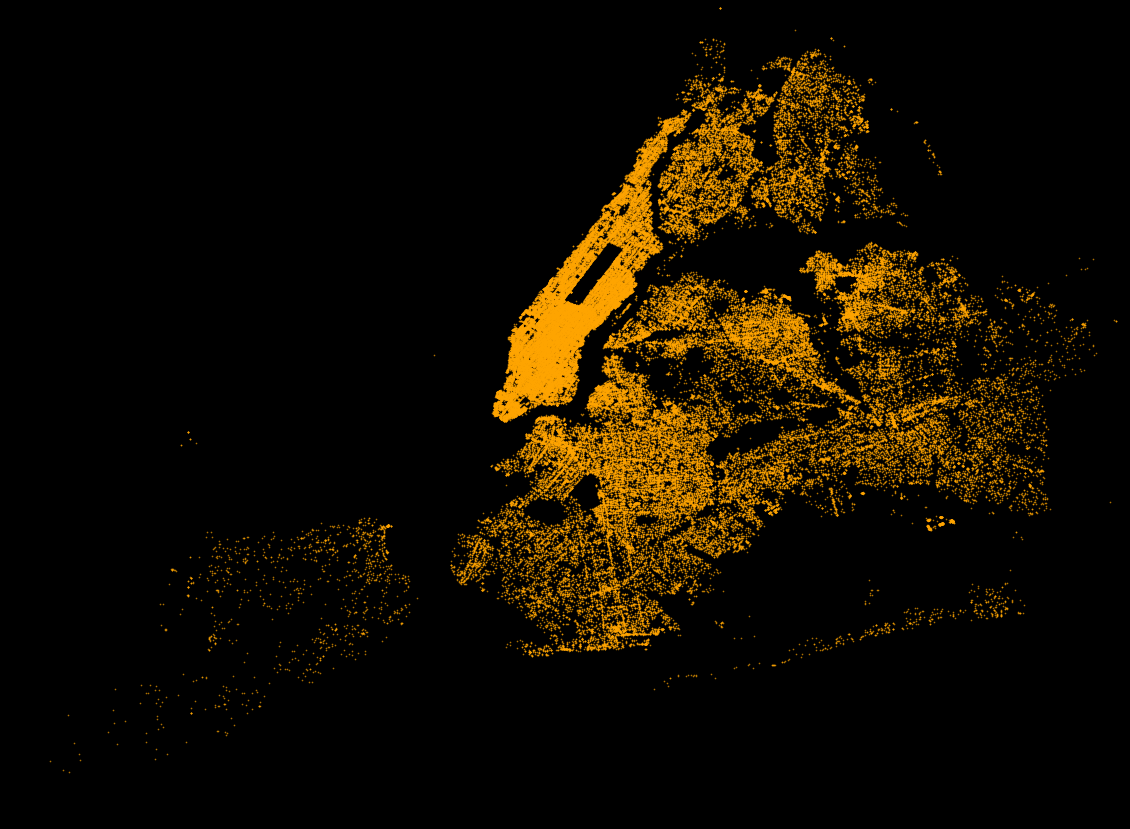

In [5]:
# plot header map
fig, ax = plt.subplots(1, figsize=(20,15))
df.plot(kind='scatter', x='Pickup_longitude', y='Pickup_latitude', color='orange', s=0.5, alpha=0.6, subplots=True, ax=ax)
ax.set_xlim(-74.273772, -73.686905)
ax.set_ylim(40.480263, 40.930138)
ax.axis('off')
fig.set_facecolor('black')

# save figure as a high-res png
fig.savefig('H:/FHV Accessibility/Research Projects/A Look into For Hire Vehicles Accessibility/Plots/header.png', 
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

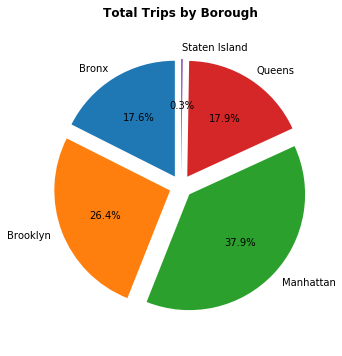

In [6]:
# create labels and sizes using data from sql query in Taxi Zones of Pickups and Dropoffs.sql
labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
sizes = [1482, 2228, 3193, 1509, 22]

# "explode all slices"
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

# plot pie chart
fig, ax = plt.subplots(figsize=(5,6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)

ax.axis('equal')
plt.title('Total Trips by Borough', fontsize=12, weight='bold')
plt.show()

# save figure as a high-res png
fig.savefig('H:/FHV Accessibility/Research Projects/A Look into For Hire Vehicles Accessibility/Plots/pie_chart.png', dpi=300)

In [7]:
# load shapefile
shapefile = "H:/FHV Accessibility/High-Volume/Plots/Shape Files/taxi_zones.shp"

shapes = gpd.read_file(shapefile)
print('rows, columns: ', shapes.shape)
shapes.head()

rows, columns:  (263, 7)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,(POLYGON ((-73.82337597260663 40.6389870471767...
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,POLYGON ((-73.84792614099985 40.87134223399991...
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,POLYGON ((-73.97177410965318 40.72582128133706...
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17421738099989 40.5625680859999,..."


In [8]:
# convert to geodataframe
geom = [point(xy) for xy in zip(df.Pickup_longitude, df.Pickup_latitude)]
crs = shapes.crs
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geom)

In [9]:
# spatial join geodataframe with df by PUlocationID
sjoin = gpd.sjoin(shapes, gdf , how='left', op='intersects').groupby(['PUlocationID']).count()[['DateTimeID']]
shapes = shapes.join(sjoin)
shapes.head()

C:\Users\changje\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,DateTimeID
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445299999996 40.6949959999999,...",NaN
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,(POLYGON ((-73.82337597260663 40.6389870471767...,11.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,POLYGON ((-73.84792614099985 40.87134223399991...,NaN
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,POLYGON ((-73.97177410965318 40.72582128133706...,229.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17421738099989 40.5625680859999,...",607.0


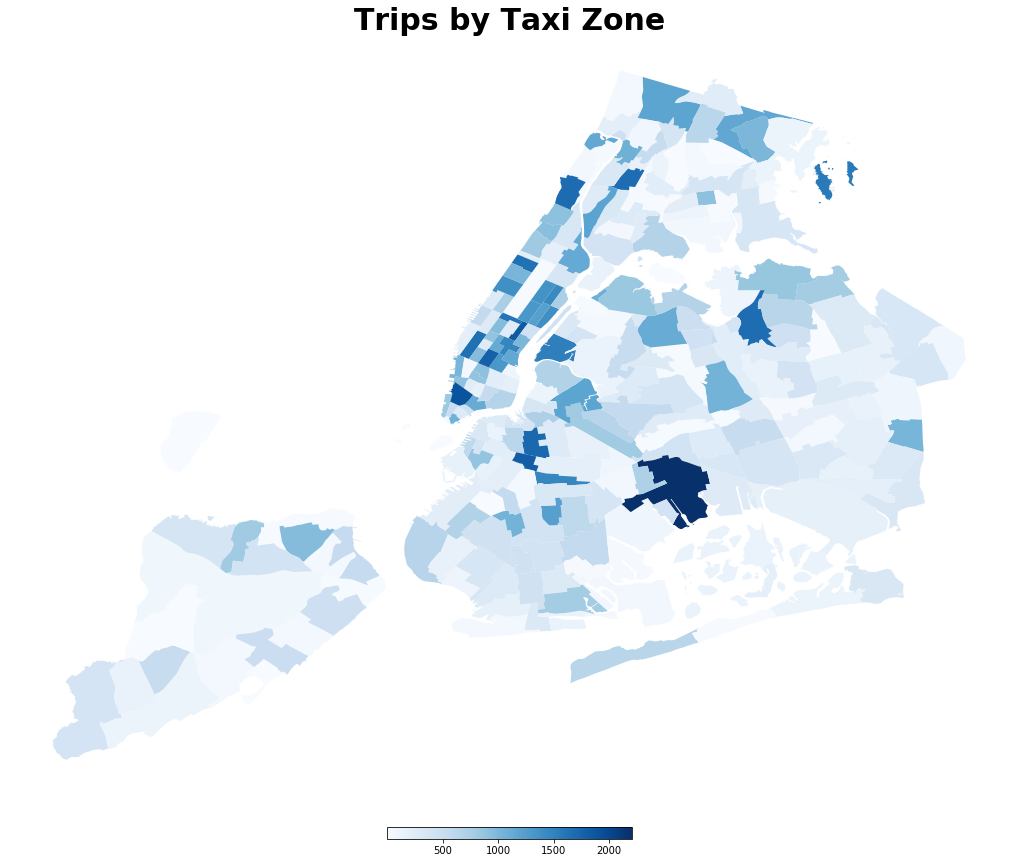

In [15]:
# create choropleth map with legend
vmin = shapes.DateTimeID.min()
vmax = shapes.DateTimeID.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='Blues')

fig, ax = plt.subplots(figsize=(18,15))
shapes.plot(column='DateTimeID', cmap='Blues', legend=False, norm=norm, ax=ax)
fig.colorbar(cbar, ax=ax, orientation='horizontal', fraction=0.015, pad=0.04)
plt.title('Trips by Taxi Zone', fontsize=30, weight='bold')
ax.axis('off')

# save figure as a high-res png
fig.savefig('H:/FHV Accessibility/Research Projects/A Look into For Hire Vehicles Accessibility/Plots/zones_choropleth.png', dpi=300)